# ユーティリティー・スケール実験 II

<Admonition type="note">
  Yukio Kawashima (12 July 2024) Translated by Hotaka Hayashi(04 October 2025)

  講義資料のPDFをこちらからダウンロードできます。現在は非推奨なコードが一部残存している可能性があることをご容赦ください。

  *この実験を実行するのに使われるQPU時間は推定2分30秒です。*

  (このノートブックでは、現在は非推奨である[チュートリアルノートブック](https://github.com/qiskit-community/qiskit-algorithms/blob/main/docs/tutorials/13_trotterQRTE.ipynb)の文章や画像、コードを用いています。)
</Admonition>



## 1. 時間発展の導入と振り返り

このノートブックは第7回で学んだ技術と方法に基づいています。今回のゴールは、時間依存のSchrödinger方程式の数値解を求めることです。第7回で見たように、トロッター分解は時間発展を細かく分割した微小時間ごとの時間発展を量子ゲートで近似するという応用を成果としています。まずは、ここでその議論を改めて復習しましょう。第7回ですでに見た部分のコードセルはスキップしていただいて構いません。

Schrödinger 方程式に従うと、初期状態が$\vert\psi(0)\rangle$の量子系の時間発展は以下のように書けます。：

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle
$$

ここで$H$はこの量子系を支配する、時間非依存のハミルトニアンです。ここでハミルトニアンを各パウリ項の重み付き和$H=\sum_j a_j P_j$で書けるとしましょう。ここで$P_j$は$n$量子ビット系に作用するパウリ行列のテンソル積です。特に、このパウリ項は互いに可換なこともそうでないこともあります。$t=0$の初期状態が与えられたとき、どのようにして時刻$t$後の状態$|\psi(t)\rangle$を、量子コンピュータを用いて得ることができるでしょうか？行列の指数関数は、テイラー展開を用いて以下のように簡単に表せます。：

$$
e^{-i H t} = 1-iHt-\frac{1}{2}H^2t^2+...
$$

$e^{iZ}$のような単純な行列指数関数は、量子コンピュータでは量子ゲートを用いて簡単に実装できます。ただし、私たちが興味のある多くのハミルトニアンはたいていの場合単一項ではなく、多くの項を持っています。$H = H_1+H_2$としたとき、以下のようになります。

$$
e^{-i H t} = 1-i(H_1+H_2)t-\frac{1}{2}(H_1+H_2)^2t^2+...
$$

$H_1$と$H_2$が可換であるならば、簡単に書くことができます。（実数$a$,$b$を用いたケースと同様です。）：

$$
e^{-i (a+b) t} = e^{-i a t}e^{-i b t}
$$

しかし演算子が可換でないならば、テイラー展開の各項はこのように簡単に書くことはできません。つまり、量子ゲートによって複雑なハミルトニアンを表現することは困難な課題なのです。

1つの解決策は、テイラー展開の1次の項が支配的となるような極めて小さな$t$を考えることです。その仮定の下では、以下の近似が成り立ちます。：

$$
e^{-i (H_1+H_2) t} \approx 1-i(H_1+H_2)t \approx (1-i H_1 t)(1-i H_2 t) \approx e^{-i H_1 t}e^{-i H_2 t}
$$

もちろん、量子状態を長時間にわたり時間発展させたものを考えたいです。これは、この小さな時間ステップを複数回繰り返すことで達成できます。この方法をトロッター分解と言います。：

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j P_j t/r} \right)^r \vert\psi(0) \rangle
$$

ここで$t/r$は我々が選択する時間ステップの長さです。量子ゲートは$r$回適用されます。より小さな時間ステップをとることでより正確な近似を得ることができますが、これは量子回路が深くなることを意味し、大きなエラーを発生させることに繋がります（近年の量子デバイスでは無視できない懸念です。）。

今回、私たちは$n=2$と$n=6$の頂点からなり、線形な格子を持つ[イジングモデル](https://en.wikipedia.org/wiki/Ising_model)の時間発展について学びます。線形な格子とは、つまりスピン$\sigma_i$は隣り合う頂点とだけ相互作用します。このスピンは2つの方向$\uparrow$と$\downarrow$を持ち、これは磁化$+1$に$-1$それぞれ対応します。

$$
H = - J \sum_{i=0}^{n-2} Z_i Z_{i+1} - h \sum_{i=0}^{n-1} X_i 
$$

$J$は相互作用のエネルギーに、$h$は外場(ここではx方向ですが、後に方向も変えます。)の強さに対応します。これをパウリ行列を用いて、また外場の方向も水平方向に対し角度$\alpha$の方向にしたものとして表現しましょう。：

$$
H = -J \sum_{i=0}^{n-2} Z_i Z_{i+1} -h \sum_{i=0}^{n-1} (\sin\alpha Z_i + \cos\alpha X_i)
$$

このハミルトニアンは外場の影響を簡単に理解するのに役立ちます。計算基底としては、この量子系は以下のように表現されます。

|       量子状態      |             スピン表現            |
| :----------------------: | :----------------------------------------: |
| $\lvert 0 0 0 0 \rangle$ |     $\uparrow\uparrow\uparrow\uparrow$     |
| $\lvert 1 0 0 0 \rangle$ |    $\downarrow\uparrow\uparrow\uparrow$    |
|         $\ldots$         |                  $\ldots$                  |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

まずは量子系の時間発展を調べることから始めましょう。具体的には、磁化のような特定の性質を持つ量子系の時間発展を可視化しましょう。


In [1]:
# Check the version of Qiskit
import qiskit

qiskit.__version__

'2.1.0'

In [2]:
# Import the qiskit library

import numpy as np
import warnings

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import LieTrotter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

warnings.filterwarnings("ignore")

## 2. 横磁場イジングハミルトニアンの定義

1次元の横磁場イジングモデルを考えましょう。

まず、系のパラメータ$n$,$J$,$h$を持つ関数を作り、そのハミルトニアンを`SparsePauliOp`に保存します。[SparsePauliOp](/docs/api/qiskit/qiskit.quantum_info.SparsePauliOp)は重み付き[Pauli](/docs/api/qiskit/qiskit.quantum_info.Pauli)項の和によって演算子をスパースに表現します。



### 2.1 実践 1

横磁場イジングハミルトニアンを作成する関数を作りましょう。引数は「量子ビット数」、「$J$」、「$h$」です。ぜひこれに挑戦しましょう。

**解答**


In [3]:
def get_hamiltonian(nqubits, J, h):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    X_tuples = [("X", [i], -h) for i in range(0, nqubits)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list(
        [*ZZ_tuples, *X_tuples], num_qubits=nqubits
    )
    return hamiltonian.simplify()

磁化の変化を追跡することで、量子系の時間発展を調べましょう。ここでは、StatevectorとMatrix Product State simulatorsの結果を比較します。

#### ハミルトニアンの定義

今回考える量子系のサイズは$n=20$です。


In [4]:
n_qubits = 20
hamiltonian = get_hamiltonian(nqubits=n_qubits, J=1.0, h=-5.0)
hamiltonian

SparsePauliOp(['IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIZZIIIIIIIII', 'IIIIIIIIZZIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIIZZIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IIZZIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIXIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIII', 'XIIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j,

#### 時間発展シミュレーションのパラメータを設定する

ここでは、1次のリー・トロッター分解を考えます。



In [5]:
num_timesteps = 20
evolution_time = 2.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()

#### 初期状態を作る量子回路の準備

初期状態を作成しましょう。ここでは、強磁性(すべてが上向きまたは下向き)を表す基底状態からシミュレーションを開始します。今回は全て上向き、つまりすべての量子ビットが'0'から始めましょう。


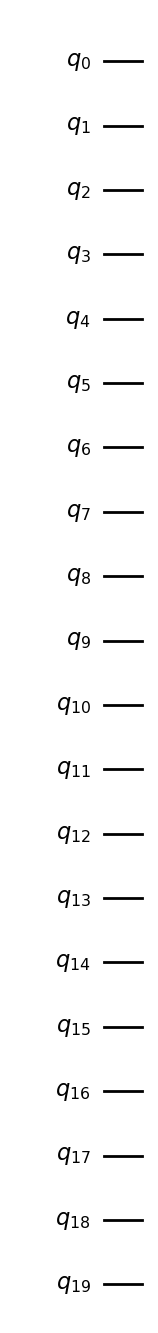

In [6]:
initial_circuit = QuantumCircuit(n_qubits)
initial_circuit.prepare_state("00000000000000000000")
# Change reps and see the difference when you decompose the circuit
initial_circuit.decompose(reps=1).draw("mpl")

#### 量子回路2を準備 (時間発展を表す回路の単位)

ここではリー・トロッター分解を用いて、1時間ステップを表す回路を作成します。1次のリー積公式は[LieTrotter](/docs/api/qiskit/qiskit.synthesis.LieTrotter)クラスを用いて実装できます。1次の公式は、行列の和の指数関数が行列指数関数の積になるという、上で述べた近似に基づいています。：

$$
e^{H_1+H_2} \approx e^{H_1} e^{H_2}
$$

ここでこの回路の実行に必要な演算の数を数えましょう。




Trotter step with Lie-Trotter
-----------------------------
Depth: 58
Gate count: 77
Nonlocal gate count: 38
Gate breakdown: CX: 38, U: 20, P: 19



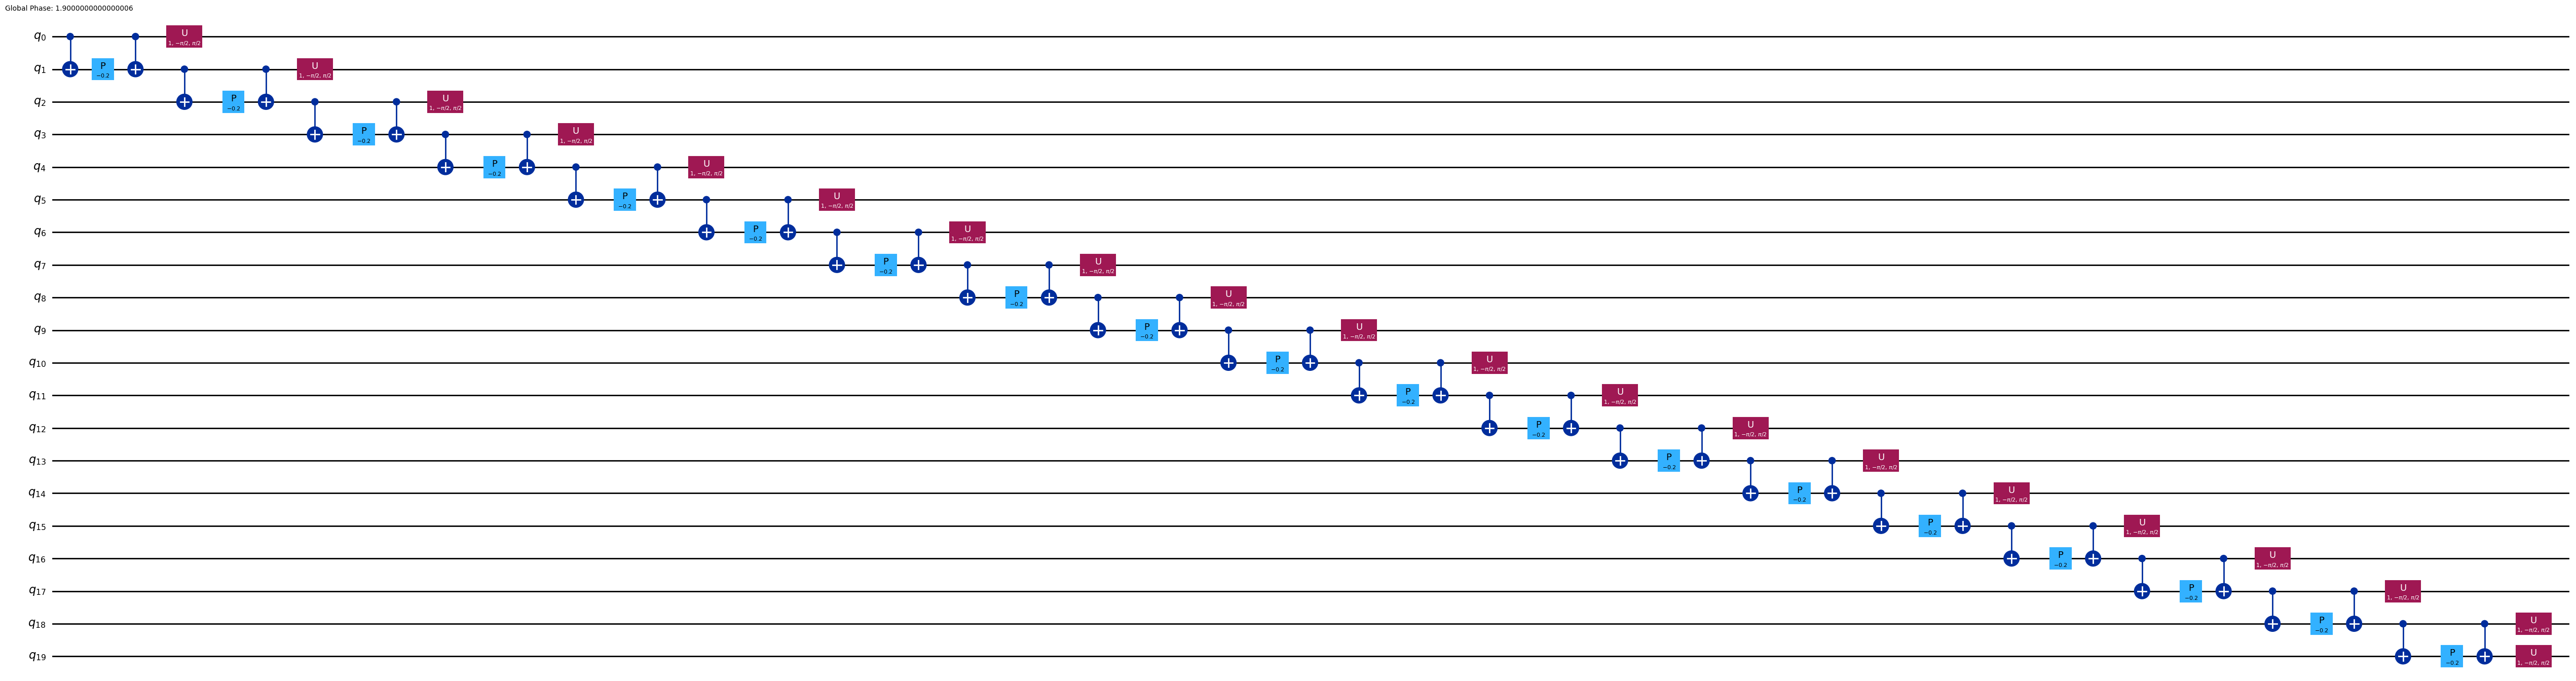

In [7]:
single_step_evolution_gates_lt = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt = QuantumCircuit(n_qubits)
single_step_evolution_lt.append(
    single_step_evolution_gates_lt, single_step_evolution_lt.qubits
)

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

#### 測定のための演算子を用意

*磁化演算子*を$\sum_i Z_i  / N$で定義します。



In [8]:
magnetization = (
    SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n_qubits)], num_qubits=n_qubits
    )
    / n_qubits
)
print("magnetization : ", magnetization)

magnetization :  SparsePauliOp(['IIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j])


#### 時間発展シミュレーションの実行

磁化（つまり磁化演算子の期待値）の発展を観察しましょう。StatevectorとMPS simulatorsの結果を比較します。



In [9]:
# Step 1. Map the problem
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)

# Define backend (simulator)
# MPS
backend_mps = AerSimulator(method="matrix_product_state")
# Statevector
backend_sv = AerSimulator(method="statevector")

# Set Runtime Estimator
# MPS
estimator_mps = Estimator(mode=backend_mps)
# Statevector
estimator_sv = Estimator(mode=backend_sv)

# Step 2. Optimize
# Set pass manager
# MPS
pm_mps = generate_preset_pass_manager(optimization_level=3, backend=backend_mps)
# Statevector
pm_sv = generate_preset_pass_manager(optimization_level=3, backend=backend_sv)

# Transpile initial circuit
# MPS
evolved_state_mps = pm_mps.run(evolved_state)
# Statevector
evolved_state_sv = pm_sv.run(evolved_state)

# Apply layout to the operator
# MPS
magnetization_mps = magnetization.apply_layout(evolved_state_mps.layout)
# Statevector
magnetization_sv = magnetization.apply_layout(evolved_state_sv.layout)

mag_mps_list = []
mag_sv_list = []

# Step 3. Run the circuit
# Estimate expectation values for t=0.0: MPS
job = estimator_mps.run([(evolved_state_mps, [magnetization_mps])])
# Get estimated expectation values: MPS
evs = job.result()[0].data.evs
# Collect data: MPS
mag_mps_list.append(evs[0])

# Estimate expectation values for t=0.0: Statevector
job = estimator_sv.run([(evolved_state_sv, [magnetization_sv])])
# Get estimated expectation values: Statevector
evs = job.result()[0].data.evs
# Collect data: Statevector
mag_sv_list.append(evs[0])

# Start time evolution
for n in range(num_timesteps):
    # Step 1. Map the problem
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_lt, evolved_state.qubits)
    # Step 2. Optimize
    # Transpile the circuit: MPS
    evolved_state_mps = pm_mps.run(evolved_state)
    # Apply the physical layout of the qubits to the operator: MPS
    magnetization_mps = magnetization.apply_layout(evolved_state_mps.layout)
    # Step 3. Run the circuit
    # Estimate expectation values at delta-t: MPS
    job = estimator_mps.run([(evolved_state_mps, [magnetization_mps])])
    # Get estimated expectation values: MPS
    evs = job.result()[0].data.evs
    # Collect data: MPS
    mag_mps_list.append(evs[0])

    # Step 2. Optimize
    # Transpile the circuit: Statevector
    evolved_state_sv = pm_sv.run(evolved_state)
    # Apply the physical layout of the qubits to the operator: Statevector
    magnetization_sv = magnetization.apply_layout(evolved_state_sv.layout)
    # Step 3. Run the circuit
    # Estimate expectation values at delta-t: Statevector
    job = estimator_sv.run([(evolved_state_sv, [magnetization_sv])])
    # Get estimated expectation values: Statevector
    evs = job.result()[0].data.evs
    # Collect data: Statevector
    mag_sv_list.append(evs[0])

# Transform the list of expectation values (at each time step) to arrays
mag_mps_array = np.array(mag_mps_list)
mag_sv_array = np.array(mag_sv_list)

#### 時間発展のプロット

時間に対して、測定した期待値をプロットします。statevectorとmatrix product space simulatorsの結果が一致していることを確かめましょう。



Text(0.5, 0.98, 'Observable evolution')

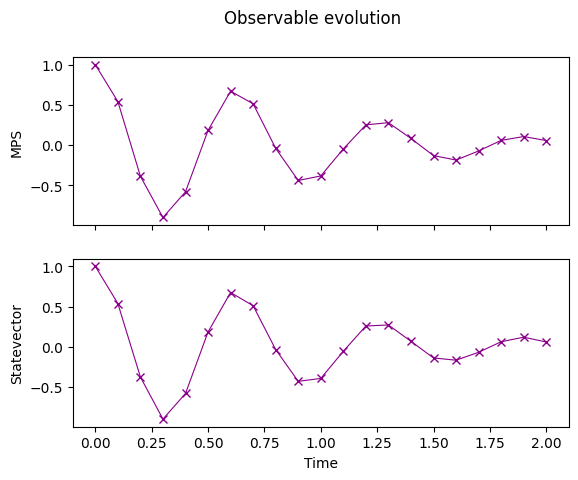

In [10]:
import matplotlib.pyplot as plt

# Step 4. Post-processing
fig, axes = plt.subplots(2, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, mag_mps_array, label="MPS", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, mag_sv_array, label="SV", marker="x", c="darkmagenta", ls="-", lw=0.8
)

axes[0].set_ylabel("MPS")
axes[1].set_ylabel("Statevector")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

特徴を示す値を追跡し、量子状態の時間発展を調査しましょう。ここでは、Matrix Product State simulatorと実際の量子デバイスにおける実験結果を比較します。

### 2.2 実践2

#### ハミルトニアンの定義

ここでは$n=70$の量子系を考えます。ほかの条件は、先ほどまでと同じとします。ぜひ挑戦してみてください。下に模範解答があります。

**解答:**



In [11]:
# Set the number of qubits
n_qubits2 = 70
# Construct the Hamiltonian by calling the function you made in Activity 1
hamiltonian2 = get_hamiltonian(nqubits=n_qubits2, J=1.0, h=-5.0)
hamiltonian2

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIII

### 2.3 実践 3

初期状態を作りましょう。先ほどと同じように、すべてが上向き('0')の基底状態とします。ぜひ挑戦してみてください。下に模範解答があります。

**解答:**



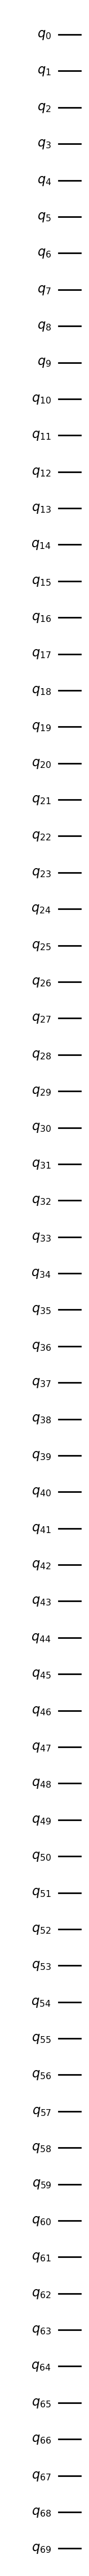

In [12]:
# Initiate the (quantum)circuit
initial_circuit2 = QuantumCircuit(n_qubits2)
# Use QuantumCircuit.prepare_state() to define the initial state
initial_circuit2.prepare_state(
    "0000000000000000000000000000000000000000000000000000000000000000000000"
)
# Change reps and see the difference when you decompose the circuit
initial_circuit2.decompose(reps=1).draw("mpl")

### 2.4 実践 4

#### 70量子ビット問題における量子回路2の準備 (時間発展回路の単位)

ここでリー・トロッター分解の1時間ステップを表す量子回路を作成します。

20量子ビットの時と全く同じく、1次のリー積公式は[LieTrotter](/docs/api/qiskit/qiskit.synthesis.LieTrotter)クラスで実装されます。

20量子ビットのときと同じように、挑戦してみてください。

**解答:**



In [13]:
# Construct the gates using PauliEvolutionGate()
single_step_evolution_gates_lt2 = PauliEvolutionGate(
    hamiltonian2, dt, synthesis=LieTrotter()
)
# Initiate the quantum circuit
single_step_evolution_lt2 = QuantumCircuit(n_qubits2)
# Append the gates defined above
single_step_evolution_lt2.append(
    single_step_evolution_gates_lt2, single_step_evolution_lt2.qubits
)

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt2.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt2.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt2.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt2.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt2.decompose(reps=3).draw("mpl", fold=-1)


Trotter step with Lie-Trotter
-----------------------------
Depth: 208
Gate count: 277
Nonlocal gate count: 138
Gate breakdown: CX: 138, U: 70, P: 69



### 2.5 実践 5

#### 測定する演算子の用意

20量子ビットの時と同じように磁化演算子を$\sum_i Z_i  / N$で定義します。20量子ビットの時と同様に、挑戦してみてください。

**解答:**



In [14]:
# Define the magnetization operator in SparsePauliOp
magnetization2 = (
    SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n_qubits2)], num_qubits=n_qubits2
    )
    / n_qubits2
)
print("magnetization : ", magnetization2)

magnetization :  SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIII

### 2.6 実践 6

#### 時間発展シミュレーション

磁化（磁化演算子の期待値）を観察しましょう。MPS simulatorを模範的な値として、量子ハードウェアの値と比較します。20量子ビットの時の例を、今回の計算に適するように変換しましょう。

**解答:**



In [15]:
# Step 1. Map the problem
# Initiate the circuit
evolved_state2 = QuantumCircuit(initial_circuit2.num_qubits)
# Start from the initial spin configuration
evolved_state2.append(initial_circuit2, evolved_state2.qubits)
# Define backend (MPs simulator)
backend_mps2 = AerSimulator(method="matrix_product_state")
# Initiate Runtime Estimator
estimator_mps2 = Estimator(mode=backend_mps2)
# Step 2. Optimize
# Initiate pass manager
pm_mps2 = generate_preset_pass_manager(optimization_level=3, backend=backend_mps2)
# Transpile
evolved_state_mps2 = pm_mps2.run(evolved_state2)
# Apply qubit layout to the observable to measure
magnetization_mps2 = magnetization2.apply_layout(evolved_state_mps2.layout)
# Initiate list
mag_mps_list2 = []
# Step 3. Run the circuit
# Estimate expectation values for t=0.0
job = estimator_mps2.run([(evolved_state_mps2, [magnetization_mps2])])
# Get estimated expectation values
evs = job.result()[0].data.evs
# Append to list
mag_mps_list2.append(evs[0])

# Start time evolution
for n in range(num_timesteps):
    # Step 1. Map the problem
    # Expand the circuit to describe delta-t
    evolved_state2.append(single_step_evolution_lt2, evolved_state2.qubits)
    # Step 2. Optimize
    # Transpile the circuit
    evolved_state_mps2 = pm_mps2.run(evolved_state2)
    # Apply the physical layout of the qubits to the operator
    magnetization_mps2 = magnetization2.apply_layout(evolved_state_mps2.layout)
    # Step 3. Run the circuit
    # Estimate expectation values at delta-t
    job = estimator_mps2.run([(evolved_state_mps2, [magnetization_mps2])])
    # Get estimated expectation values
    evs = job.result()[0].data.evs
    # Append to list
    mag_mps_list2.append(evs[0])
# Transform the list of expectation values (at each time step) to arrays
mag_mps_array2 = np.array(mag_mps_list2)

これまで学んだように、Qiskitパターンフレームワークに基づいて実装します。ここまで取り組んだことは、問題を説明するための量子回路を適切に作ることに基づいています。これがStep1です。

#### Step 2: ターゲットハードウェアに対する最適化

ますはターゲットバックエンドを定義します。



In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_torino'

量子回路をトランスパイルし、リストに格納します。これには数分かかることがあります。



In [19]:
pm_hw = generate_preset_pass_manager(optimization_level=3, backend=backend)
circuit_isa = []
# Step 1. Map the problem
evolved_state_hw = QuantumCircuit(initial_circuit2.num_qubits)
evolved_state_hw.append(initial_circuit2, evolved_state_hw.qubits)
# Step 2. Optimize
circuit_isa.append(pm_hw.run(evolved_state_hw))

for n in range(num_timesteps):
    # Step 1. Map the problem
    evolved_state_hw.append(single_step_evolution_lt2, evolved_state_hw.qubits)
    # Step 2. Optimize
    circuit_isa.append(pm_hw.run(evolved_state_hw))

#### Step 3: ターゲットハードウェアでの実行

Runtime Estimatorを定義し、PUBのリストを作成します。また観測のための演算子を適用します。



In [20]:
# Step 2. Optimize
estimator_hw = Estimator(mode=backend)
pub_list = []
for circuit in circuit_isa:
    temp = (circuit, magnetization2.apply_layout(circuit.layout))
    pub_list.append(temp)

ジョブを実行する準備ができました。



In [21]:
job = estimator_hw.run(pub_list)
job_id = job.job_id()
print(job_id)

d3gbc7c1nk1s739negg0


In [26]:
# check job status
job.status()

'DONE'

#### Step 4: 結果の後処理

まずは結果を取得します。


In [27]:
job = service.job(job_id)
pub_result = job.result()

これらの結果から期待値を取得します。

In [28]:
mag_hw_list = []
for res in pub_result:
    evs = res.data.evs
    mag_hw_list.append(evs)

以下で、この結果を比較のために使います。まずは、量子回路が最適化されているかを確認しましょう。

## 3. 実際の量子コンピュータによるソリューションII

Qiskitパターン step 1に立ち戻り、量子回路の深さを減らせていることを確かめましょう。

### 3.1 Step 1 問題を量子回路と演算子にマッピングする

#### 実践7

時間発展回路を実装します。これまで学習した知識を用いて、量子回路の深さを減らすことに挑戦しましょう。

**解答:**




Trotter step with Lie-Trotter
-----------------------------
Depth: 7
Gate count: 277
Nonlocal gate count: 138
Gate breakdown: CX: 138, U: 70, P: 69



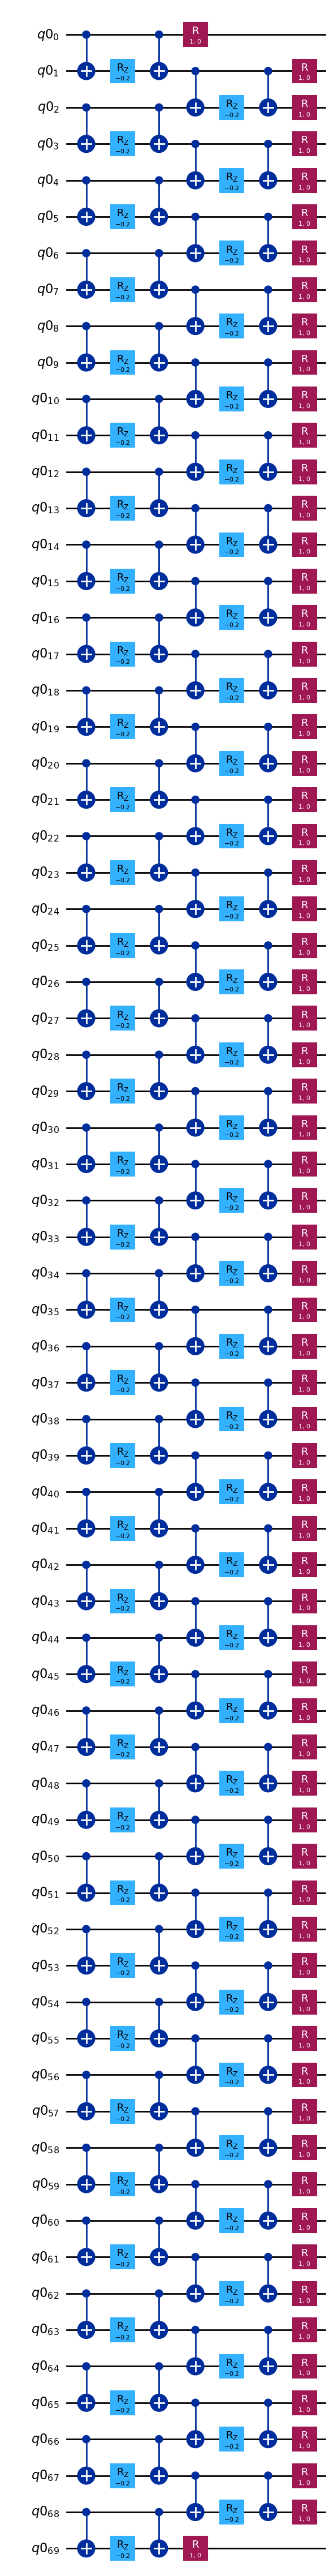

In [29]:
# Define J
J = 1.0
# Define h
h = -5.0
# Create instruction for rotation around ZZ:
# Initiate the circuit (use 2 qubits)
Rzz_circ = QuantumCircuit(2)
# Add Rzz gate (do not forget to multiply the angle by 2.0)
Rzz_circ.rzz(-J * dt * 2.0, 0, 1)
# Transform the QuantumCircuit to instruction (QuantumCircuit.to_instruction())
Rzz_instr = Rzz_circ.to_instruction(label="RZZ")

# Create instruction for rotation around X:
# Initiate the circuit (use 1 qubit)
Rx_circ = QuantumCircuit(1)
# Add Rx gate (do not forget to multiply the angle by 2.0)
Rx_circ.rx(-h * dt * 2.0, 0)
# Transform the QuantumCircuit to instruction (QuantumCircuit.to_instruction())
Rx_instr = Rx_circ.to_instruction(label="RX")

# Define the interaction list
interaction_list = [
    [[i, i + 1] for i in range(0, n_qubits2 - 1, 2)],
    [[i, i + 1] for i in range(1, n_qubits2 - 1, 2)],
]  # linear chain

# Define the registers
qr = QuantumRegister(n_qubits2)
# Initiate the circuit
single_step_evolution_sh = QuantumCircuit(qr)
# Construct the Rzz gates
for i, color in enumerate(interaction_list):
    for interaction in color:
        single_step_evolution_sh.append(Rzz_instr, interaction)

# Construct the Rx gates
for i in range(0, n_qubits2):
    single_step_evolution_sh.append(Rx_instr, [i])

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_sh.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_sh.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_sh.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_sh.decompose(reps=3).count_ops().items()])}
"""
)

single_step_evolution_sh.decompose(reps=2).draw("mpl")

成功しましたね。次のQiskitパターンのStepに進むことができます。

### 3.2 Step 2 ターゲットハードウェア向けに最適化する

リストに入れた量子回路をトランスパイルしましょう。再度、これは数分かかる可能性があります。



In [31]:
pm_hw2 = generate_preset_pass_manager(backend=backend, optimization_level=3)
circuit_isa2 = []
# Step 1. Map the problem
evolved_state_hw2 = QuantumCircuit(initial_circuit2.num_qubits)
evolved_state_hw2.append(initial_circuit2, evolved_state_hw2.qubits)
# Step 2. Optimize
circuit_isa2.append(pm_hw2.run(evolved_state_hw2))
for n in range(num_timesteps):
    # Step 1. Map the problem
    evolved_state_hw2.append(single_step_evolution_sh, evolved_state_hw2.qubits)
    # Step 2. Optimize
    circuit_isa2.append(pm_hw2.run(evolved_state_hw2))

Runtime Estimatorを定義し、PUBのリストを作成します。


In [32]:
estimator_hw2 = Estimator(mode=backend)
pub_list2 = []
for circuit in circuit_isa2:
    temp = (circuit, magnetization2.apply_layout(circuit.layout))
    pub_list2.append(temp)

### 3.3 Step 3. ターゲットハードウェアで実行します。

ジョブを実行します。



In [33]:
job2 = estimator_hw2.run(pub_list2)
job2_id = job2.job_id()
print(job2_id)

d3gvqq9b641c738lnm90


In [39]:
# check job status
job2.status()

'DONE'

結果を得る。



In [40]:
job2 = service.job(job2_id)
pub_result2 = job2.result()

### 3.4 Step 4. 後処理

結果から期待値を取得します。


In [41]:
mag_hw_list2 = []
for res in pub_result2:
    evs = res.data.evs
    mag_hw_list2.append(evs)

リストをnumpy arrayに変換し、プロットします。


In [42]:
mag_hw_array = np.array(mag_hw_list)
mag_hw_array2 = np.array(mag_hw_list2)

結果をプロットし、量子ハードウェアとMPS simulatorの結果を比較しましょう。実際の量子エラーが結果にどのように影響するでしょうか？


Text(0.5, 0.98, 'Observable evolution')

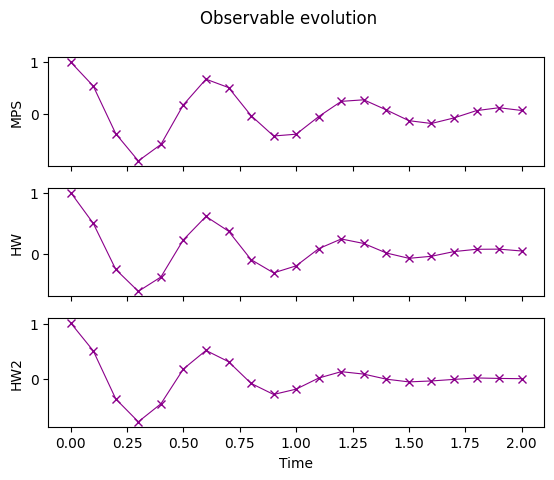

In [43]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, mag_mps_array2, label="MPS", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, mag_hw_array, label="HW", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, mag_hw_array2, label="HW2", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("MPS")
axes[1].set_ylabel("HW")
axes[2].set_ylabel("HW2")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

おめでとうございます！量子ユーティリティ・スケールの1つのステップをクリアしました。残るレッスンは1つだけです！


© IBM Corp., 2017-2025